In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
!wget http://www.manythings.org/anki/deu-eng.zip #-P data/   #(by default it saves in ./ )

--2019-11-19 07:00:15--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7612057 (7.3M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   7.26M  19.0MB/s    in 0.4s    

2019-11-19 07:00:20 (19.0 MB/s) - ‘deu-eng.zip’ saved [7612057/7612057]



In [ ]:
!unzip deu-eng.zip

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [ ]:
file = open("deu.txt",mode="rt",encoding="utf-8")
data=file.read()

In [ ]:
# split a text into sentences
def to_lines(text):
    sent=text.strip().split("\n")
    sent=[r.split("\t") for r in sent]
    return sent

In [ ]:
deu_eng = to_lines(data)
deu_eng = np.array(deu_eng)
print(deu_eng[:5])

[['Hi.' 'Hallo!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)']
 ['Hi.' 'Grüß Gott!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)']
 ['Run!' 'Lauf!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)']
 ['Wow!' 'Potzdonner!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122382 (Pfirsichbaeumchen)']
 ['Wow!' 'Donnerwetter!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)']]


In [ ]:
deu_eng = deu_eng[:50000,:]

In [ ]:
import string
deu_eng[:,0] = [s.translate(str.maketrans('','',string.punctuation)).lower() for s in deu_eng[:,0]]   # sari rows ke first column yani english wale
deu_eng[:,1] = [s.translate(str.maketrans('','',string.punctuation)).lower() for s in deu_eng[:,1]]   

In [ ]:
deu_eng

array([['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ['run', 'lauf',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)'],
       ...,
       ['i wholeheartedly agree', 'ich stimme rückhaltlos zu',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1488273 (Spamster) & #1693172 (al_ex_an_der)'],
       ['i will always love you', 'ich werde dich immer lieben',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #853146 (piksea) & #395302 (xtofu80)'],
       ['i will be back by nine', 'um neun bin ich wieder zurück',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #72281 (CK) & #345033 (lilygilder)']],
      dtype='<U537')

In [ ]:
# eng_1= []
# deu_1= []

# for i in deu_eng[:,0]:
#   eng_1.append(len(i.split()))

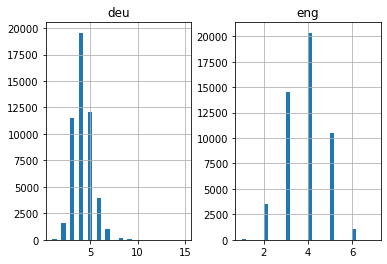

In [ ]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()


In [ ]:
from keras.preprocessing.text import Tokenizer
def tokenization(line):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(line)
  return tokenizer

In [ ]:
eng_tokenizer= tokenization(deu_eng[:,0])
deu_tokenizer= tokenization(deu_eng[:,1])


eng_vocab_size=len(eng_tokenizer.word_index)+1
deu_vocab_size=len(deu_tokenizer.word_index)+1

print(eng_vocab_size)
print(deu_vocab_size)



6361
10597


In [ ]:
from keras.preprocessing.sequence import pad_sequences
def encode_sequences(tokenizer,length,lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(seq,maxlen= length,padding="post")
  return seq

In [ ]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(deu_eng,test_size=0.2,random_state=12)   # set seed = 12   0.2 means testing 20% and training 80%


In [ ]:
trainX  = encode_sequences(deu_tokenizer , 8 , train[:,1])
trainY  = encode_sequences(eng_tokenizer , 8 , train[:,0])

testX  = encode_sequences(deu_tokenizer , 8 , train[:,1])
testY  = encode_sequences(eng_tokenizer , 8 , train[:,0])

print(trainX.shape)
print(trainX[0])

print(trainY.shape)
print(trainY[0])

(40000, 8)
[203 102  48 397   0   0   0   0]
(40000, 8)
[ 11   3  23  16 385   0   0   0]


In [ ]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,RepeatVector
from keras import optimizers

model=Sequential()
model.add(Embedding(deu_vocab_size, 512,input_length=8))
model.add(LSTM(512))
model.add(RepeatVector(8))
model.add(LSTM(512, return_sequences=True))
model.add(Dense(eng_vocab_size,activation='softmax'))
model.compile(optimizer=optimizers.RMSprop(lr= 0.001), loss='sparse_categorical_crossentropy')

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model.h1",
                             monitor = "val_loss",
                             verbose =1,
                             save_best_only= True,
                             mode= "min")

history=model.fit(trainX,
                  trainY.reshape(trainY.shape[0],trainY.shape[1],1),
                  epochs = 30,
                  batch_size = 512,
                  validation_split = 0.2,
                  callbacks = [checkpoint],
                  verbose =1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 32000 samples, validate on 8000 samples
Epoch 1/30





32000/32000 [==============================] - 22s 678us/step - loss: 3.3918 - val_loss: 2.9435

Epoch 00001: val_loss improved from inf to 2.94347, saving model to model.h1
Epoch 2/30
32000/32000 [==============================] - 15s 458us/step - loss: 2.8838 - val_loss: 2.8747

Epoch 00002: val_loss improved from 2.94347 to 2.87474, saving model to model.h1
Epoch 3/30
32000/32000 [==============================] - 15s 457us/step - loss: 2.7332 - val_loss: 2.7495

Epoch 00003: val_loss improved from 2.87474 to 2.74949, saving model to model.h1
Epoch 4/30
32000/32000 [==============================] - 15s 457us/step - loss: 2.5909 - val_loss: 2.6221

Epoch 00004: val_loss improved from 2.74949 to 2.62213, saving model to model.h1
Epoch 5/30
32000/32000 [==============================] - 15s 456us/step - loss: 2.4545 - val_los

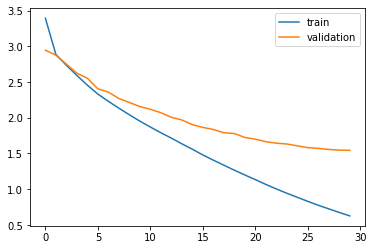

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
from keras.models import load_model

model = load_model("model.h1")
preds = model.predict_classes(testX)

In [ ]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None


In [ ]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))


In [ ]:
print(preds_text)

['do you like my shoes   ', 'i was tired and cold   ', 'toms speech bored me    ', 'tom hates children     ', 'i love this chair    ', 'its very cheap     ', 'tom looks shaken     ', 'i thought that too    ', 'im on the     ', 'hes innocent      ', 'youre the expert     ', 'is this your son    ', 'it was simple     ', 'please hurry      ', 'i am to     ', 'why isnt tom home    ', 'is that what tom said   ', 'give me a  party   ', 'it cant take long    ', 'you have no evidence    ', 'keep the dog     ', 'this isnt enough     ', 'tom will never     ', 'get some      ', 'hes has lung     ', 'i dont understand you    ', 'did you go with tom   ', 'tom has a beard    ', 'the dog is dying    ', 'nobody else  there    ', 'ill call you     ', 'were counting on you    ', 'ill get the 230    ', 'i been      ', 'isnt it black     ', 'im very happy     ', 'its is      ', 'dont go      ', 'wait the      ', 'i hate winter     ', 'i need your     ', 'i knew it be very   ', 'come back soon     ', 'come

In [ ]:
print(train[:,0])

['do you like my shoes' 'i was tired and cold' 'toms speech bored me' ...
 'i wanted sympathy' 'the woman is reading' 'he painted a dog']


In [ ]:
print(test[:,0])

['you need to wake up' 'i feel old' 'im sorry tom' ... 'tom is a con man'
 'why arent you there' 'how do we stop tom']


In [ ]:
pred_df = pd.DataFrame({'actual' : train[:,0], 'predicted' : preds_text})

In [ ]:
pred_df.head(15)

,actual,predicted
0,do you like my shoes,do you like my shoes
1,i was tired and cold,i was tired and cold
2,toms speech bored me,toms speech bored me
3,tom hates children,tom hates children
4,i love this chair,i love this chair
5,its very cheap,its very cheap
6,tom looks shaken,tom looks shaken
7,i thought that too,i thought that too
8,im hitting the road,im on the
9,hes innocent,hes innocent


In [ ]:

pred_df.tail(15)

,actual,predicted
39985,dig a deep hole,tom was a
39986,tom is nervous,tom is
39987,did you go to college,do you go to
39988,the clock is fast,the is ended
39989,it goes both ways,its is in day
39990,i bought you a present,i bought you a book
39991,tom can run fast,tom can swim fast
39992,get lost,go away
39993,tom hated lying,tom hates that
39994,youd love tom,you believe tom


In [ ]:
pred_df.sample(15)

,actual,predicted
30151,i know what to study,i know what to like
36672,coal is a fossil fuel,is a new
33115,i think they saw you,i think you saw you
9001,dont remind me,dont remind me
30490,im going to see tom,ill going to
36862,i understand,i do understand
30461,tom is frightened,tom is frightened
30605,i wont tell anyone,i wont tell anyone
11125,tom cooked the books,tom cooked the
6558,tom cant read,tom cant read
